# Portfolio Optimization - FTSE 100 Stocks
In this project we will be focused on the 10 largest companies listed on the London Stock Exchange (LSE) by market capitalization, intending to understand how they can be integrated into an optimal investment portfolio, whose optimization will be carried out through Monte Carlo Simulation and PyPortfolioOpt Optimizer. The aim is also to compare the performance of each portfolio over time, namely in terms of tail risk, by estimating Value at Risk (VaR) and Conditional Value at Risk (CVaR or Expected Shortfall) for different time frames.
https://github.com/FLopes045/Portfolio-Optimization--FTSE-100-Stocks/blob/main/README.md

# 1. Import Libraries

In [46]:
import yfinance as yf
import numpy as np
import pandas as pd
import datetime as dt
import scipy.stats as stats

from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
import seaborn as sns

# 2. Loading the data and Pre-processing

In [69]:
# Read the company info 
company_info = pd.read_csv("FTSE100_Top10Companies_Info.csv")
company_info.head()

Ticker         Company              Sector  \
0  SHEL.L           Shell              Energy   
1   AZN.L     AstraZeneca          Healthcare   
2  HSBA.L   HSBC Holdings          Financials   
3  ULVR.L  Unilever Group  Consumer Defensive   
4    BP.L              BP              Energy   

                                   Industry  Founded  Employees  \
0                                 Oil & Gas     1907      82000   
1                           Pharmaceuticals     1999      83100   
2                          Banking Services     1865     219697   
3  Personal & Household Products & Services     1929     148012   
4                                 Oil & Gas     1909      65900   

   Market Cap (M)  
0       170958.35  
1       164063.78  
2       120808.42  
3       103789.98  
4        93363.01

In [116]:
# Stock data extraction from YahooFinance API. (Note: to calculate stock betas, we added FTSE 100 index to the 
# years = 11
# end_date = dt.datetime.now()
# start_date = end_date - dt.timedelta(days = 365*years)

tickers = company_info['Ticker'].tolist()
prices = yf.download(tickers,"2012-01-31",dt.date.today())["Close"]
market_price = yf.download('^FTSE',"2012-01-31",dt.date.today())["Close"]
prices = pd.concat([market_price,prices,],axis=1)


# Converting datetime format
prices.reset_index(inplace=True)
prices['Date'] = prices['Date'].dt.strftime('%Y/%m/%d')
prices['Date'] = pd.to_datetime(prices['Date'])
prices.set_index('Date',inplace=True)


[*********************100%%**********************]  10 of 10 completed
[*********************100%%**********************]  1 of 1 completed


In [118]:
# Renaming columns
prices.columns =['FTSE 100'] + prices.columns.tolist()[1:]
prices.columns = company_info['Company'].to_list() + prices.columns.tolist()[:1]

# Filling missing values with interpolation
prices = prices.interpolate(method="nearest")
prices.tail().round(1)

# Save prices to csv
prices.to_csv('FTSE100_Top10Companies_Prices.csv')


In [74]:
# Calculating simple price returns
returns = prices.pct_change().dropna()

# Extracting stock returns and market returns 
stock_returns = returns.iloc[:,:-1]
market_returns = pd.Series(returns['FTSE 100'])

# 3. Description analysis of simple and cumulative returns

#### Daily returns

In [75]:
# Descriptive statistics of daily returns 
summary = round(stock_returns.describe().T,4)
summary['Skew'] = stats.skew(stock_returns._get_numeric_data()).round(4)
summary['Kurt'] = stats.kurtosis(stock_returns._get_numeric_data()).round(4)
summary = summary.drop('count',axis=1)
summary

mean     std     min     25%     50%     75%  \
Shell                     0.0001  0.0098 -0.1087 -0.0045  0.0006  0.0050   
AstraZeneca               0.0005  0.0148 -0.1541 -0.0067  0.0006  0.0080   
HSBC Holdings             0.0000  0.0141 -0.1062 -0.0071  0.0004  0.0080   
Unilever Group            0.0002  0.0184 -0.1948 -0.0085  0.0000  0.0086   
BP                        0.0003  0.0126 -0.0869 -0.0062  0.0003  0.0071   
Diageo                    0.0004  0.0266 -0.2942 -0.0129  0.0006  0.0133   
Rio Tinto Group           0.0001  0.0123 -0.1006 -0.0065  0.0003  0.0068   
Glencore                  0.0002  0.0150 -0.0952 -0.0071  0.0001  0.0077   
British American Tobacco  0.0003  0.0200 -0.1178 -0.0107  0.0004  0.0114   
GlaxoSmithKline           0.0002  0.0175 -0.1760 -0.0074  0.0004  0.0085   

                             max    Skew     Kurt  
Shell                     0.0905 -0.6127  10.9940  
AstraZeneca               0.1438 -0.1517  11.0778  
HSBC Holdings             0.0760 -0.3759   4.1846  
Unilever Group            0.2158  0.1854  15.1041  
BP                        0.0984  0.2020   6.1698  
Diageo                    0.2105 -0.2018  11.1222  
Rio Tinto Group           0.0754 -0.2785   5.1061  
Glencore                  0.1072  0.0574   4.8018  
British American Tobacco  0.1469  0.1112   2.9694  
GlaxoSmithKline           0.2038 -0.0799  15.0959

Shell, AstraZeneca, HSBC Holdings, Diageo, Rio Tinto Group and GlaxoSmithKline have a negatively skewed distribution, i.e, 
their returns are more concentrated on the right tail of the distribution, whose tail is longer on the left side. Its investors should
expect frequent small gains and some large losses.

All stocks feature heavy tails (or that their distribution is leptokurtic), with some of them having a kurtosis greater than 10.
Consequently, these stocks will experience more frequent extreme returns (large outliers).

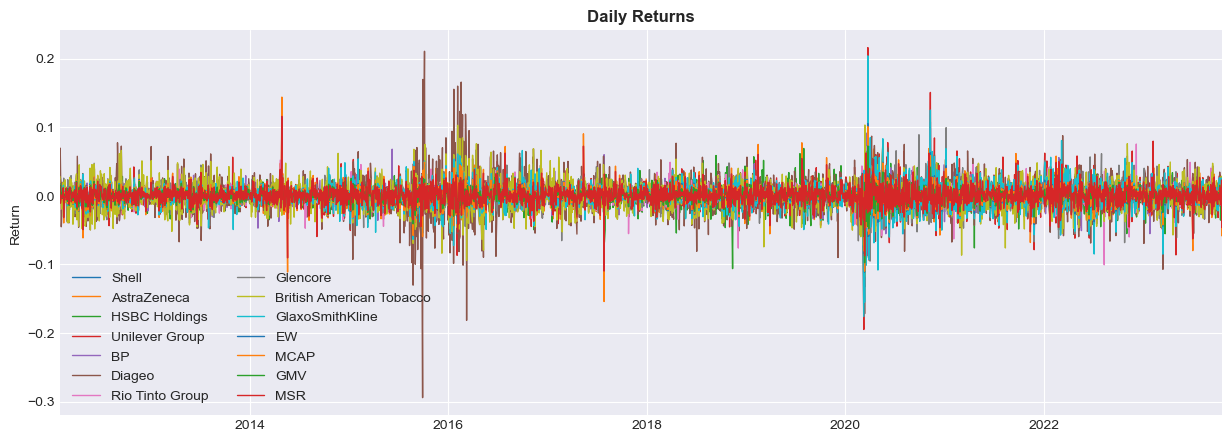

In [122]:
# Line plot function
def line_plot(data, legend_loc, legend_ncol, title, ylabel):
    plt.figure(figsize=(15,5))
    for col in data:
        plt.plot(data.index, data[col], marker='', linewidth=1, label=col)
        plt.legend(loc=legend_loc, ncol=legend_ncol)
        plt.margins(x=0)
        plt.title(title, weight='bold')
        plt.ylabel(ylabel)
    plt.show()
    
# Plotting daily returns
line_plot(data=stock_returns, legend_loc='lower left', legend_ncol=2,
            title='Daily Returns', ylabel='Return')
        

Text(0.5, 1.0, 'Daily Returns Distribution')

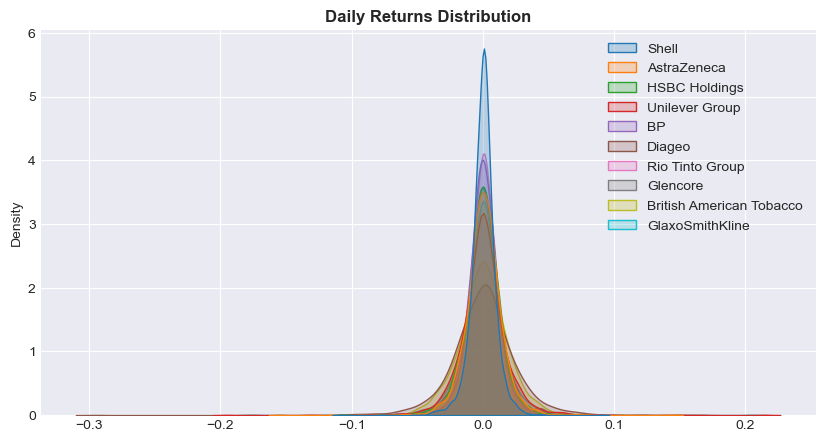

In [77]:
# Daily Returns distribution
fig = plt.figure(figsize=(10,5))
sns.kdeplot(data=stock_returns, fill=True)
plt.title('Daily Returns Distribution',weight='bold')

We can notice the wider distributions for Diageo and British American Tobacco, meaning these companies have higher volatility associated.

In [78]:
# Minimum and maxim returns dates
ret_min_max_dates = pd.DataFrame({'Min Return': stock_returns.idxmin(),
                                 'Max Return': stock_returns.idxmax()})
ret_min_max_dates

Min Return Max Return
Shell                    2020-03-12 2020-03-24
AstraZeneca              2017-07-27 2014-04-28
HSBC Holdings            2018-11-12 2020-03-24
Unilever Group           2020-03-09 2020-03-24
BP                       2020-03-23 2020-11-09
Diageo                   2015-09-28 2015-10-05
Rio Tinto Group          2022-08-11 2022-12-07
Glencore                 2020-04-01 2020-11-09
British American Tobacco 2020-03-12 2020-03-24
GlaxoSmithKline          2020-03-09 2020-03-24

It appears that most of these stocks had their lowest and highest returns in early 2020, close to the Covid-19 pandemic, which demonstrates the high volatility and financial contagion associated with that period.

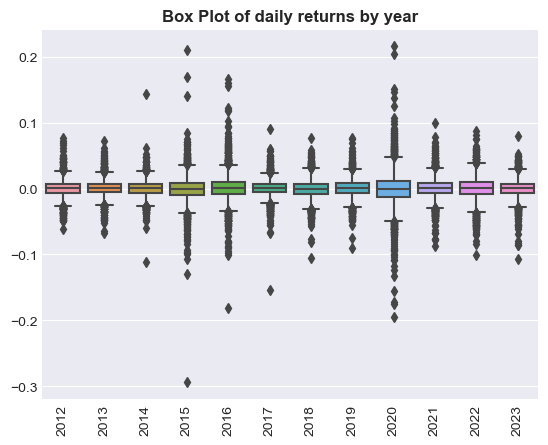

In [79]:
# Box Plot of daily returns by year
returns_by_year = pd.melt(stock_returns.reset_index(),id_vars='Date')
returns_by_year['Year'] = pd.DatetimeIndex(returns_by_year['Date']).year
returns_by_year
ax = sns.boxplot(data = returns_by_year, x='Year',y='value')
ax.set_title('Box Plot of daily returns by year', weight='bold')
ax.set_ylabel(''), ax.set_xlabel('')
for item in ax.get_xticklabels():
    item.set_rotation(90)

We can also observe the high volatility in the pandemic first year through this box plot of all returns grouped by year. There is a greater dispersion of data at 2020.

In [80]:
# Risk-Return profile
ret_stats = stock_returns.agg(['mean','std']).T
ret_stats.columns=['Return','Risk']
ret_stats['Return'] = ret_stats['Return']*252
ret_stats['Risk'] = ret_stats['Risk']*np.sqrt(252)
ret_stats['Sharpe_Ratio']=(ret_stats['Return']-0.03510)/ret_stats['Risk'] # rf: US 10y Bond Yield at January 31,2023
ret_stats = ret_stats.sort_values('Sharpe_Ratio', ascending=False)
ret_stats.round(3)

Return   Risk  Sharpe_Ratio
AstraZeneca                0.132  0.234         0.414
BP                         0.087  0.200         0.261
Diageo                     0.094  0.422         0.141
British American Tobacco   0.072  0.317         0.117
GlaxoSmithKline            0.056  0.279         0.074
Unilever Group             0.055  0.292         0.069
Glencore                   0.041  0.238         0.025
Shell                      0.035  0.155        -0.003
Rio Tinto Group            0.022  0.195        -0.069
HSBC Holdings              0.010  0.224        -0.110

The Sharpe Ratio is understood as the stock (or portfolio) excess return divided by standard deviation of returns.

    AstraZeneca has the highest Sharpe ratio: the investiment provides 0.45 units of return for each unit of risk;

    HSBC Holdings and Rio Tinto have negative Sharpe ratios, i.e., both didn't rent more than treasury bills over period, so they may not be worth it for investors who wish to maximize their portfolio ajusted returns.

Text(0.5, 1.0, 'Risk-Return profile')

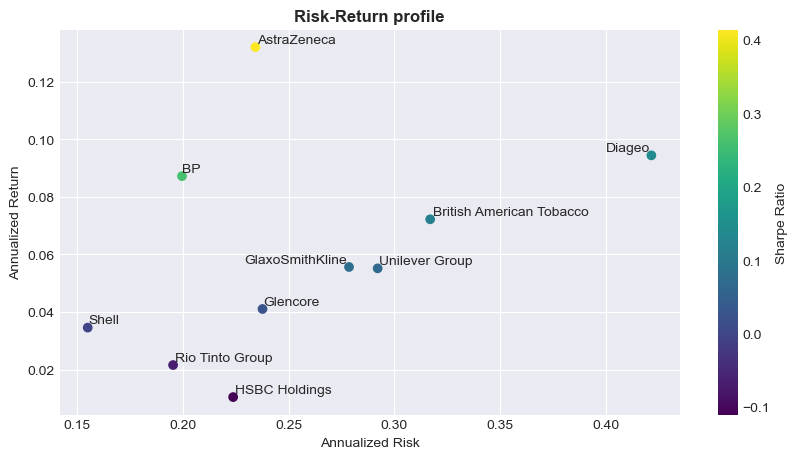

In [81]:
# Plotting annualized Risk, Return and Sharpe Ratio
from adjustText import adjust_text
fig = plt.figure(figsize=(10,5))
plt.scatter(data=ret_stats,x='Risk',y='Return', c='Sharpe_Ratio', cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
texts = []
for x, y, s in zip(ret_stats['Risk'],ret_stats['Return'], ret_stats.index):
    texts.append(plt.text(x,y,s))
adjust_text(texts)
plt.xlabel('Annualized Risk'), plt.ylabel('Annualized Return')
plt.title('Risk-Return profile', weight='bold')

In [82]:
# Measuring stock volatility through Beta
betas = []
for i in range(len(stock_returns.columns)):
    beta = np.polyfit(market_returns, stock_returns.iloc[:,i],1)[0]
    betas.append(beta)
betas = pd.DataFrame(betas, columns=['Beta'], index=company_info['Company'])
betas = betas.sort_values('Beta',ascending=False)
betas.round(3)

Beta
Company                        
BP                        0.544
HSBC Holdings             0.514
Rio Tinto Group           0.442
AstraZeneca               0.432
Shell                     0.396
Glencore                  0.362
GlaxoSmithKline           0.337
Diageo                    0.326
Unilever Group            0.324
British American Tobacco  0.262

Beta coefficient measures the volatility of a security (or portfolio) compared to the systematic risk of the entire market, so it describes how security's returns responds to swings on the market;

    Since all stocks have beta less than one, we can say that they all have lower volatility than the market, that is, the inclusion of each one of them in a portfolio makes it less risky than the same portfolio without that stock.

### Cumulative daily returns

In [83]:
# Calculation of cumulative returns, as the growth of £1 
cum_returns = ((1 + stock_returns).cumprod()-1)*100

# Rates of change for each company share
ticker_change = cum_returns.tail(1).round(3)
ticker_change

Shell  AstraZeneca  HSBC Holdings  Unilever Group       BP  \
Date                                                                      
2023-10-20  30.282      241.463        -15.838          15.833  120.578   

            Diageo  Rio Tinto Group  Glencore  British American Tobacco  \
Date                                                                      
2023-10-20   5.885            2.931    16.273                     29.58   

            GlaxoSmithKline  
Date                         
2023-10-20           21.736

AstraZeneca and BP clearly stand out as the stocks with the highest growth, being the only ones with a rate of change greather than 100%.
On the other hand, Rio Tinto Group stock increased even less than 1%.

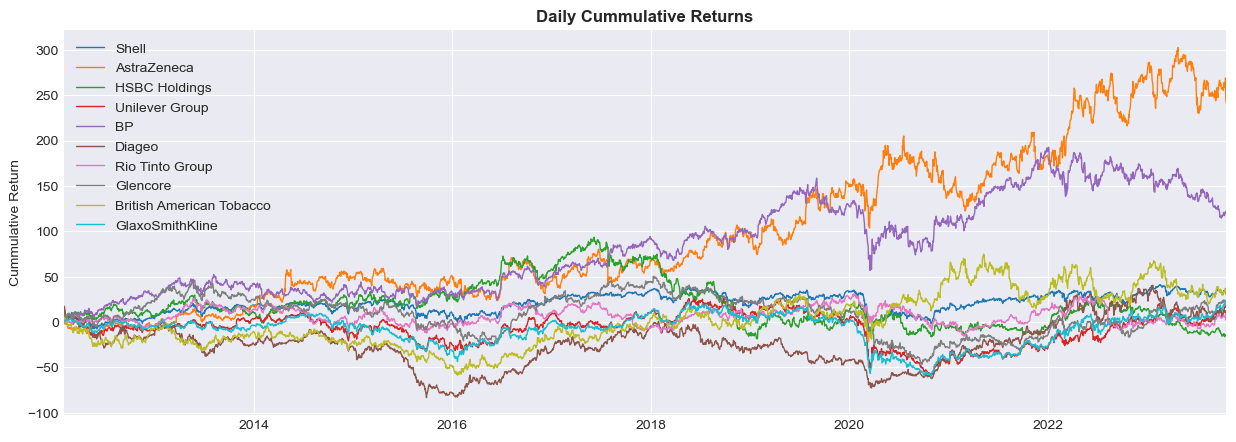

In [84]:
# Plotting daily cummulative returns
line_plot(data=cum_returns, legend_loc='upper left', legend_ncol=1,
            title='Daily Cummulative Returns', ylabel='Cummulative Return')

Cumulative returns declined during the Covid-19 shock. Particularly, Shell had a big drop to negative values, as a result of the sudden drop in the oil demand following the implementation of restrictions.

AstraZeneca kept a growth trend throughout the entire period.

### Correlation and Covariance matrices

Text(0.5, 1.0, 'Correlation Heatmap')

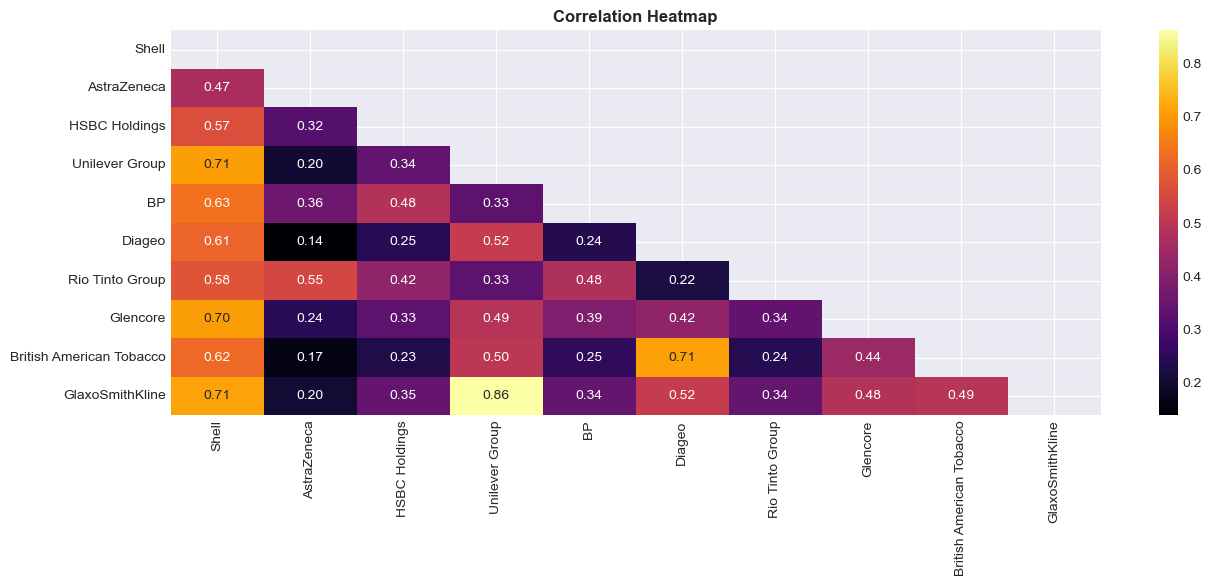

In [85]:
# Correlation Heatmap
import seaborn as sns
plt.figure(figsize=(15,5))
mask = np.triu(np.ones_like(stock_returns.corr(), dtype=bool))
my_cmap = sns.diverging_palette(10, 220, sep=80, n=50)
sns.heatmap(stock_returns.corr(), mask=mask, annot=True, fmt=".02f", cmap='inferno')
plt.title('Correlation Heatmap', weight='bold')

We can see that Shell is highly correlated with the remaining stocks, which may be due to its importance in the market, being the most highly-valued british company;

On the othe hand, the second largest british company - AstraZeneca - appears to be the least correlated with the market.

In [86]:
# Annual Covariance matrix
cov_matrix = stock_returns.cov(numeric_only=True)*252
cov_matrix.round(4)

Shell  AstraZeneca  HSBC Holdings  Unilever Group  \
Shell                     0.0240       0.0170         0.0196          0.0320   
AstraZeneca               0.0170       0.0549         0.0167          0.0138   
HSBC Holdings             0.0196       0.0167         0.0500          0.0223   
Unilever Group            0.0320       0.0138         0.0223          0.0853   
BP                        0.0196       0.0169         0.0216          0.0193   
Diageo                    0.0399       0.0137         0.0231          0.0637   
Rio Tinto Group           0.0175       0.0250         0.0183          0.0190   
Glencore                  0.0259       0.0136         0.0176          0.0341   
British American Tobacco  0.0304       0.0123         0.0164          0.0466   
GlaxoSmithKline           0.0308       0.0133         0.0216          0.0701   

                              BP  Diageo  Rio Tinto Group  Glencore  \
Shell                     0.0196  0.0399           0.0175    0.0259   
AstraZeneca               0.0169  0.0137           0.0250    0.0136   
HSBC Holdings             0.0216  0.0231           0.0183    0.0176   
Unilever Group            0.0193  0.0637           0.0190    0.0341   
BP                        0.0398  0.0198           0.0185    0.0186   
Diageo                    0.0198  0.1777           0.0181    0.0421   
Rio Tinto Group           0.0185  0.0181           0.0381    0.0157   
Glencore                  0.0186  0.0421           0.0157    0.0565   
British American Tobacco  0.0161  0.0950           0.0148    0.0332   
GlaxoSmithKline           0.0190  0.0608           0.0186    0.0320   

                          British American Tobacco  GlaxoSmithKline  
Shell                                       0.0304           0.0308  
AstraZeneca                                 0.0123           0.0133  
HSBC Holdings                               0.0164           0.0216  
Unilever Group                              0.0466           0.0701  
BP                                          0.0161           0.0190  
Diageo                                      0.0950           0.0608  
Rio Tinto Group                             0.0148           0.0186  
Glencore                                    0.0332           0.0320  
British American Tobacco                    0.1004           0.0435  
GlaxoSmithKline                             0.0435           0.0776

## 2. Portfolio optimization

### 2.1 GMV and MSR Portfolios

    Portfolio Optimization via Monte Carlo Method

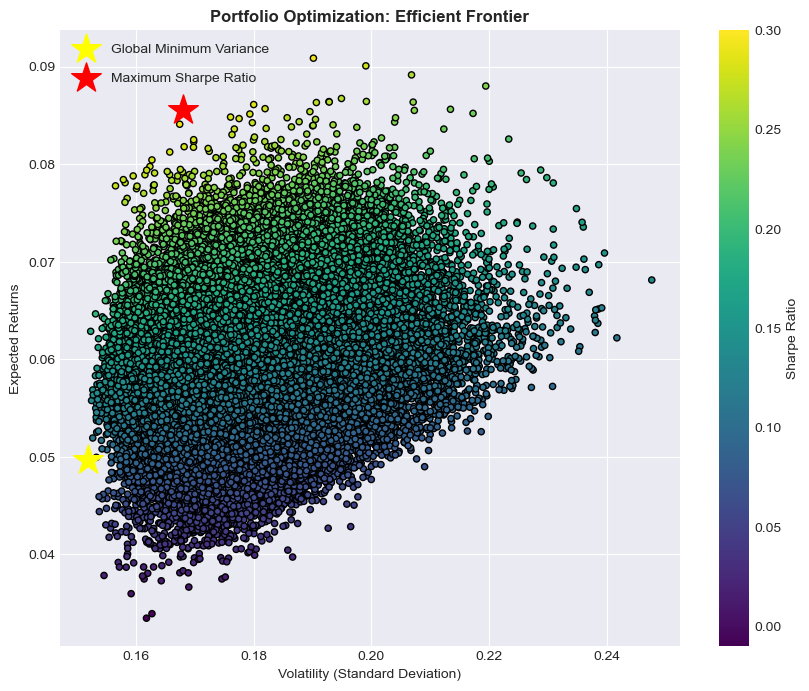

In [87]:
mean_ret = stock_returns.mean()*252
std_returns = stock_returns.std()*np.sqrt(252)

assets_num=len(tickers)
port_num=50000
port_ret=[]
port_vol=[]
port_weights=[]
sharpe_ratio=[]

for portfolio in range(port_num):
    weights = np.random.random(assets_num)
    weights /= np.sum(weights)
    ret = np.dot(weights, mean_ret)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix,weights)))
    rf = 0.03510 # US 10y Bond Yield at January 31,2023
    sharpe = (ret-rf)/vol
    sharpe_ratio.append(sharpe)
    port_ret.append(ret)
    port_vol.append(vol)
    port_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
port_dict = {'Returns': port_ret,
             'Volatility': port_vol,
             'Sharpe Ratio': sharpe_ratio}

for counter,symbol in enumerate(company_info['Company'].to_list()):
    port_dict[symbol] = [Weight[counter] for Weight in port_weights]

port_EF = pd.DataFrame(port_dict)

gmv_port_value = port_EF['Volatility'].min()
msr_port_value = port_EF['Sharpe Ratio'].max()

gmv_port = port_EF.loc[port_EF['Volatility'] == gmv_port_value]
msr_port = port_EF.loc[port_EF['Sharpe Ratio'] == msr_port_value]

port_EF.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio',
                cmap='viridis', edgecolors='black', figsize=(10, 8), grid=True)
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Returns')
plt.title('Portfolio Optimization: Efficient Frontier', weight='bold')
plt.scatter(x=gmv_port['Volatility'], y=gmv_port['Returns'], c='yellow', marker='*', s=500, label='Global Minimum Variance')
plt.scatter(x=msr_port['Volatility'], y=msr_port['Returns'], c='red', marker='*', s=500, label='Maximum Sharpe Ratio')
plt.legend(labelspacing=1.2)
plt.grid(True)
plt.show()

In [88]:
# Global Minimum Variance Portfolio (GMV) 
gmv_port.round(3)


Returns  Volatility  Sharpe Ratio  Shell  AstraZeneca  HSBC Holdings  \
34326     0.05       0.152         0.096  0.207        0.164          0.162   

       Unilever Group     BP  Diageo  Rio Tinto Group  Glencore  \
34326           0.016  0.063   0.003            0.213     0.132   

       British American Tobacco  GlaxoSmithKline  
34326                     0.019            0.019

In [89]:
# Maximum Sharpe Ratio Portfolio (MSR)
msr_port.round(3)

Returns  Volatility  Sharpe Ratio  Shell  AstraZeneca  HSBC Holdings  \
34636    0.086       0.168           0.3  0.008        0.218           0.01   

       Unilever Group     BP  Diageo  Rio Tinto Group  Glencore  \
34636            0.02  0.382   0.113            0.028     0.128   

       British American Tobacco  GlaxoSmithKline  
34636                     0.008            0.085

#### Using PyPortfolioOpt library for optimization

In [90]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

rf = 0.03510 # US 10y Bond Yield at January 31,2023
stock_prices = prices.iloc[:,:-1]
mu = expected_returns.mean_historical_return(stock_prices)
S = risk_models.sample_cov(stock_prices)
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1)) # Weights between 0 and 1, ie, no short-selling

# Maximun Sharpe Ratio (MSR) Portfolio
opt_msr = ef.max_sharpe(risk_free_rate=rf)
weights_msr = ef.clean_weights()
print('-----------------------------')
print("\033[1m" + "Portfolio Performance:")
print('-----------------------------')
print('Max Sharpe Portfolio:\n')
print(ef.portfolio_performance(verbose=True, risk_free_rate = rf)[:-3])

print('\nGlobal Min Variance Portfolio:\n')
ef = EfficientFrontier(mu, S, weight_bounds=(0, 1)) # Weights between 0 and 1, ie, no short-selling
opt_gmv = ef.min_volatility()
weights_gmv = ef.clean_weights()
print(ef.portfolio_performance(verbose=True, risk_free_rate = rf)[:-3])

-----------------------------
Portfolio Performance:
-----------------------------
Max Sharpe Portfolio:

Expected annual return: 10.2%
Annual volatility: 20.4%
Sharpe Ratio: 0.33
()

Global Min Variance Portfolio:

Expected annual return: 3.0%
Annual volatility: 14.7%
Sharpe Ratio: -0.04
()


### 2.2 Equally-Weighted Portfolio
Each stock counts equally toward the portfolio value.

In [91]:
numstocks = 10
weights_ew = np.repeat(1/numstocks,numstocks)
ew_df= pd.DataFrame(weights_ew, index=ret_stats.index, columns=['EW'])

### 2.3 Market Cap-Weighted Portfolio
In this portfolio, the weighting of each stock is determined by its total market capitalization.

In [92]:
mcap = np.array(company_info['Market Cap (M)'])
mcap_weights = mcap/sum(mcap)
mcap_df= pd.DataFrame(mcap_weights, index=ret_stats.index, columns=['MCAP'])

# 3. Analysis of optimized Portfolios' Performance
In this section we will be focused on the last four portfolios generated:
    
    Equally-Weighted, Market-Cap Weighted, Minimum Variance and Tangency Portfolio (Maximum Sharpe Ratio)

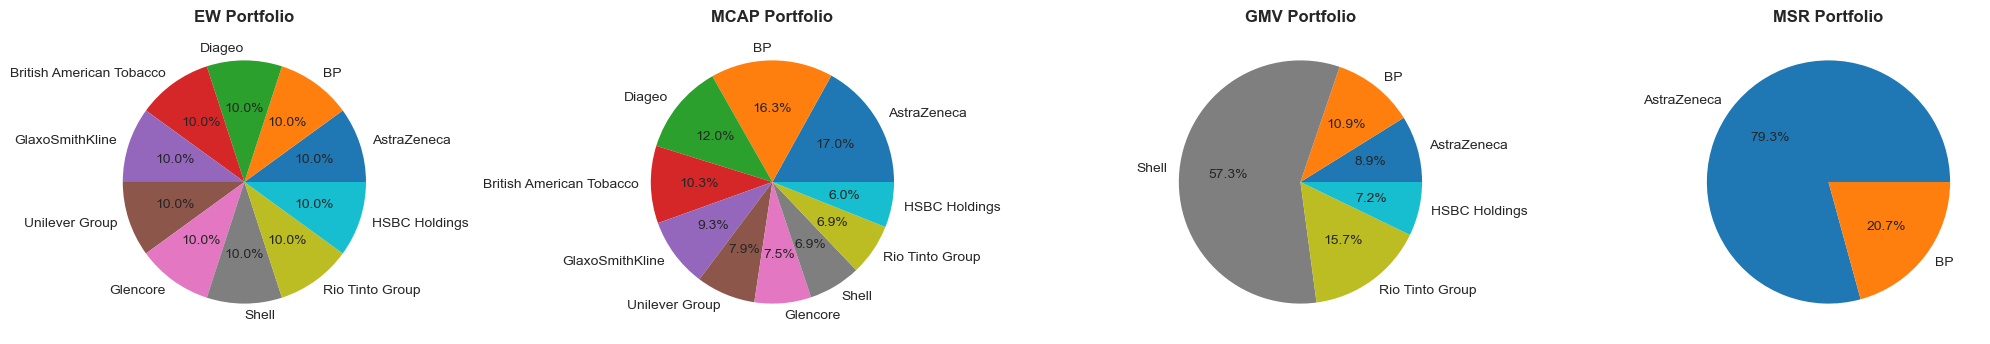

In [93]:
# Portolio weights
gmv_df = pd.DataFrame.from_dict(weights_gmv, orient='index')
gmv_df.columns = ['GMV']

msr_df = pd.DataFrame.from_dict(weights_msr, orient='index')
msr_df.columns = ['MSR']

weights_df = pd.concat([ew_df, mcap_df, gmv_df, msr_df],axis=1)

fig = plt.figure(figsize=(20,10))
colours = dict(zip(weights_df.index, plt.cm.tab10.colors[:len(weights_df.index)]))
for column,num in zip(weights_df.columns, range(len(weights_df.columns))):
    plt.subplot(1,4,num+1)
    labels, values = zip(*((key,value) for key,value in weights_df[column].items() if value>0))
    plt.pie(values, labels=labels, colors=[colours[key] for key in labels], autopct='%1.1f%%')
    plt.title('{} Portfolio'.format(column), weight='bold')
    fig.tight_layout()
plt.show()

In [94]:
# Calculating portfolio returns
stock_returns = pd.concat([stock_returns,stock_returns.dot(weights_df)], axis=1)
portfolio_returns = stock_returns.iloc[:,-4:]

Text(0.5, 1.0, 'Box Plot of Daily Returns')

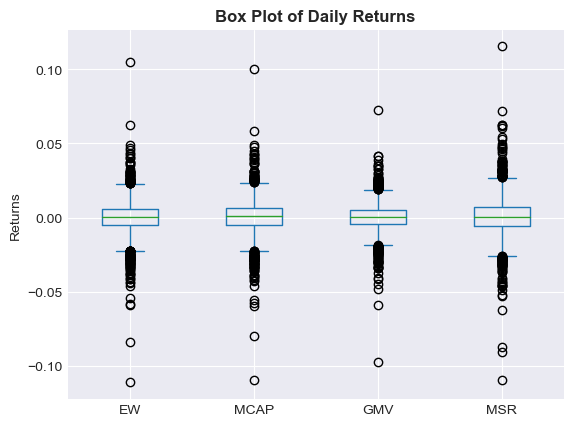

In [95]:
# Volatility Analysis
# Box plot are applied to visualize the returns dispersion of each portfolio
portfolio_returns.plot(kind='box', ylabel="Returns")
plt.title("Box Plot of Daily Returns", weight='bold')

As expected, the returns of minimum variance portfolio are less dispersed than the other ones, having a lower interquartile range.

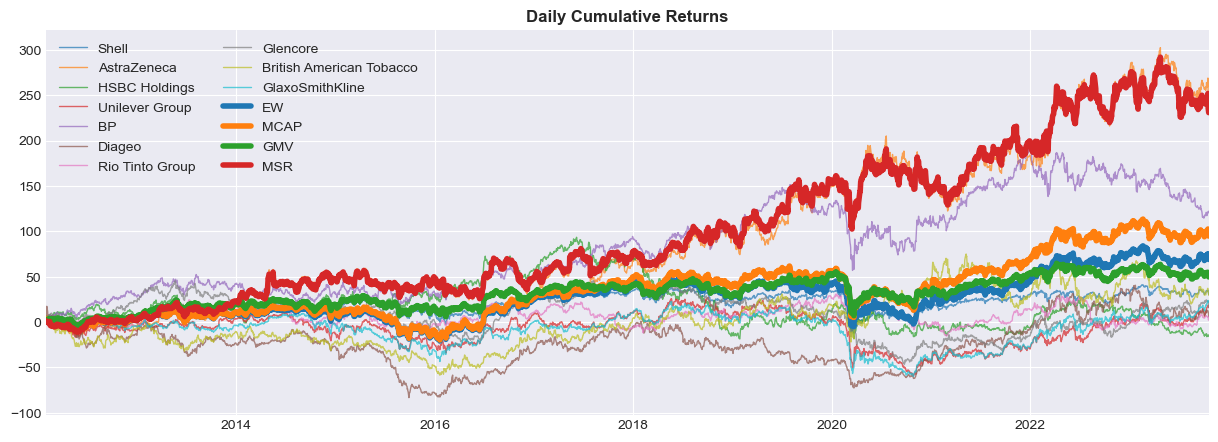

In [96]:
# Comparing cumulative returns of individual assets and optimized portfolios
cum_returns = ((1 + stock_returns).cumprod() - 1)*100

fig = plt.figure(figsize=(15,5))
colors=['r', 'g', 'b']
for x in cum_returns:
        if x in cum_returns.columns[:-4]:
                plt.plot(cum_returns.index, cum_returns[x], marker='',
                linewidth=1, alpha=0.7, label=x)
        else:
                plt.plot(cum_returns.index, cum_returns[x], marker='',
                        linewidth=4, alpha=1, label=x)
plt.title('Daily Cumulative Returns', weight='bold')
plt.legend(loc='upper left', ncol=2)
plt.margins(x=0)
plt.show()

Text(0.5, 1.0, 'Annualized Sharpe Ratios')

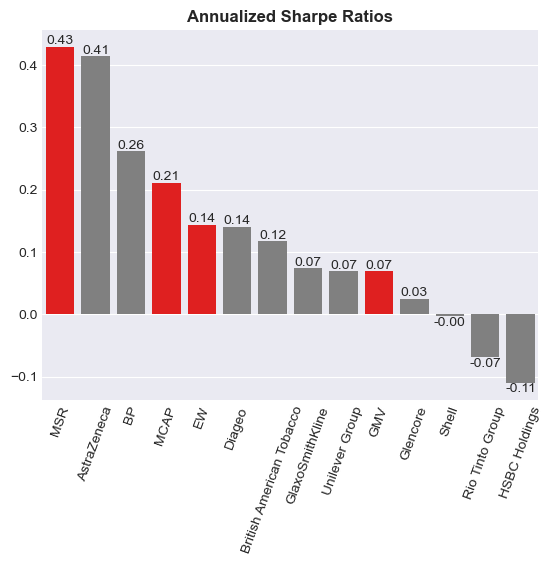

In [97]:
# Annualized Sharpe Ratios
sharpe = (stock_returns.mean()*252-rf) / (stock_returns.std()*np.sqrt(252))
sharpe = sharpe.sort_values(ascending=False)

palette = ['red' if (x=='MSR' or x=='GMV' or x=='MCAP' or x=='EW') else 'grey' for x in sharpe.index]
ax = sns.barplot(x=sharpe.index, y=sharpe.values, palette=palette)
plt.xticks(rotation=70)
ax.bar_label(ax.containers[0], fmt='%.2f')
plt.title('Annualized Sharpe Ratios', weight='bold')

### Rolling statistics

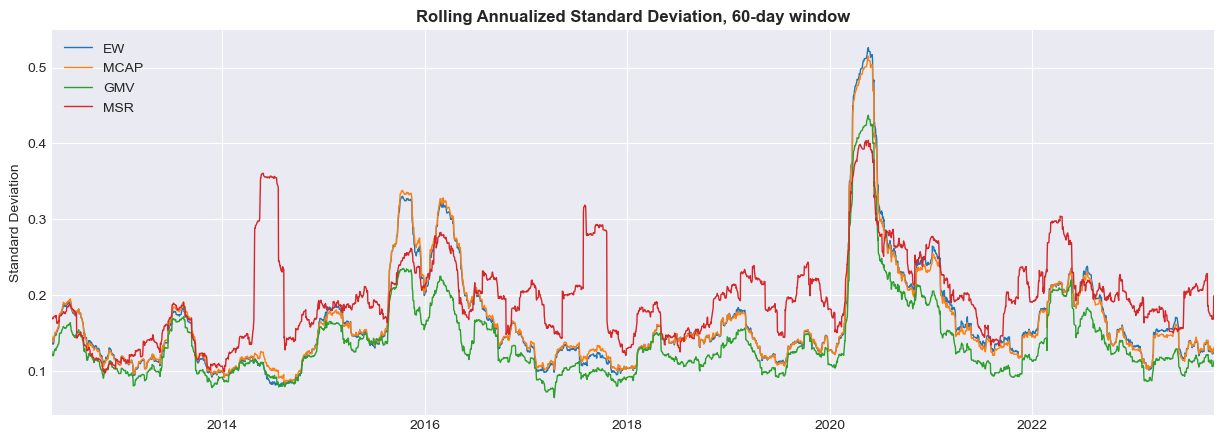

In [98]:
# Portfolios' volatility over time
port_vol = portfolio_returns.rolling(60).std().dropna()*np.sqrt(252) # 30-day rolling window
port_vol = port_vol.dropna()

# Plotting rolling annualized standard deviation
line_plot(data=port_vol, legend_loc='upper left', legend_ncol=1,
            title='Rolling Annualized Standard Deviation, 60-day window',
            ylabel='Standard Deviation')

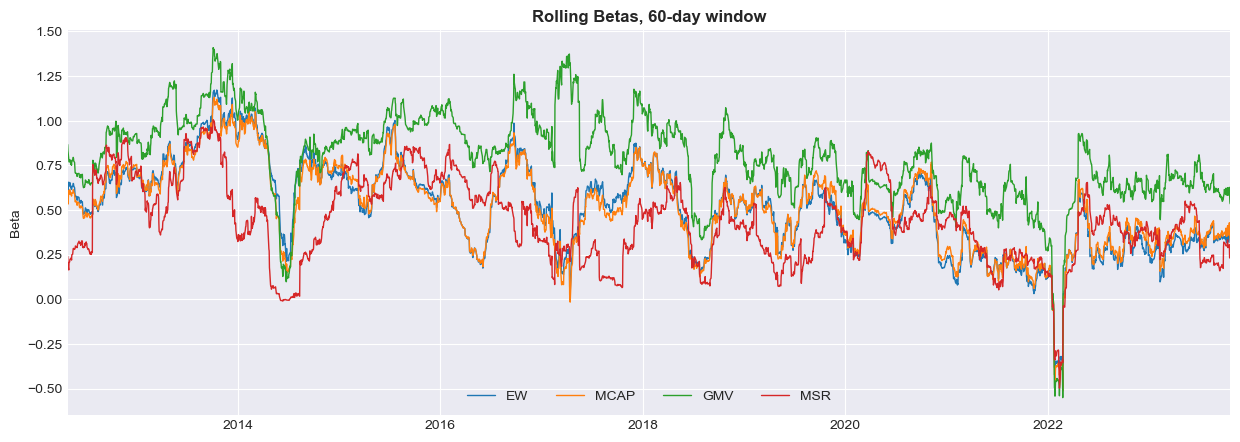

In [99]:
# Rolling betas
covariance = portfolio_returns.rolling(60).cov(market_returns)
variance = portfolio_returns.rolling(60).var()
rolling_beta = covariance.div(variance)
rolling_beta = rolling_beta.dropna()

# Plotting portfolio Betas
line_plot(data=rolling_beta, legend_loc='lower center', legend_ncol=4,
            title='Rolling Betas, 60-day window', ylabel='Beta')

According to the graph, the maximum sharpe ratio portfolio seems to be less sensitive to the market, at least before 2020.

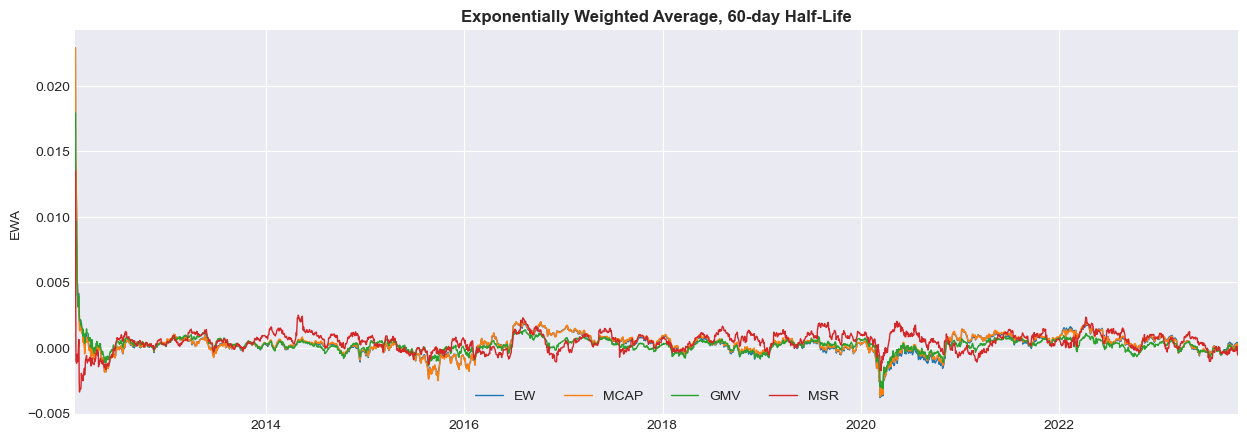

In [100]:
# Exponentially Weighted Average
ewa = portfolio_returns.ewm(halflife=60).mean()

line_plot(data=ewa, legend_loc='lower center', legend_ncol=4,
            title='Exponentially Weighted Average, 60-day Half-Life',
            ylabel='EWA')

<Figure size 1500x500 with 0 Axes>

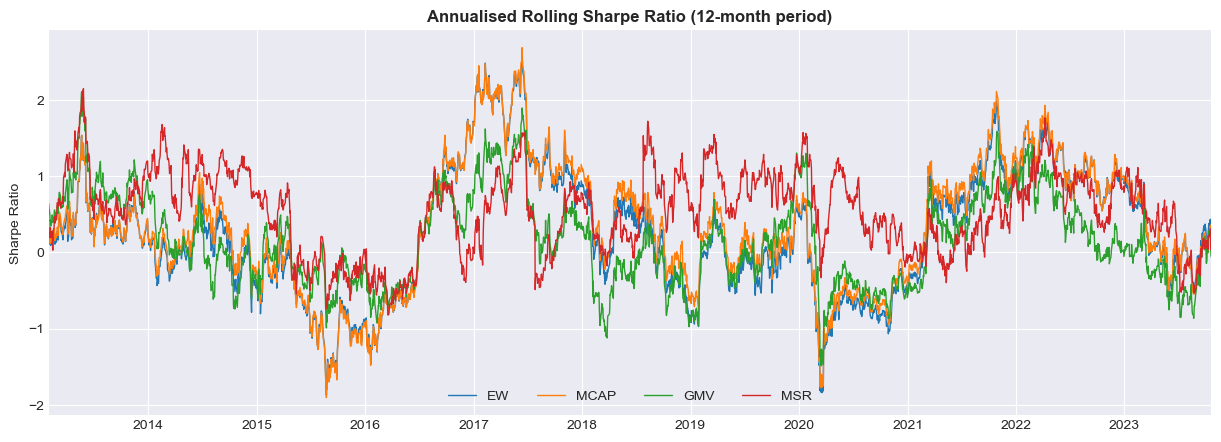

In [101]:
# Annualized Rolling Sharpe Ratio (12 month window)
rolling_sr = portfolio_returns.rolling(252).apply(lambda x: ((x.mean()*252)-rf)/(x.std()*np.sqrt(252)), raw=True)
rolling_sr = rolling_sr.dropna()

plt.figure(figsize=(15,5))
line_plot(data=rolling_sr, legend_loc='lower center', legend_ncol=4,
            title='Annualised Rolling Sharpe Ratio (12-month period)',
            ylabel='Sharpe Ratio')

The rolling estimate provides us with more information than single point estimate for the entire period, allowing to infer whether the risk-adjusted returns are consistent over time or it fluctuates significantly.

As we can see, the SR are volatile which maymay indicate that the portfolios may be riskier at certain time points, namely before 2016 and during Covid-19 crisis, or that it does not perform as well at these time points.

# 4. Tail Risk Analysis
Tail risk include low-probability events arising at both ends of a normal distribution curve, also known as tail events.

## 4.1 Historical Drawdown

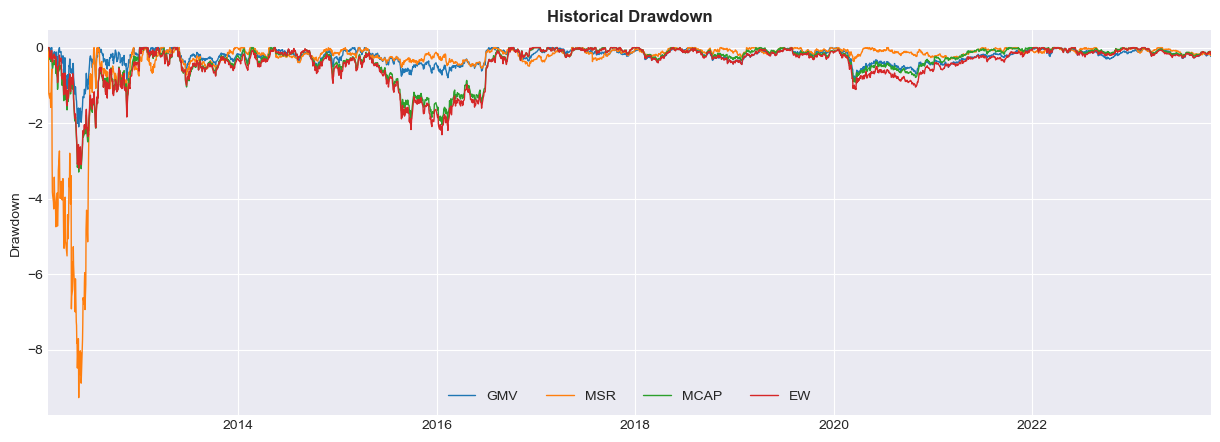

In [102]:
# Historical drawdown
running_max = np.maximum.accumulate(cum_returns[['GMV','MSR','MCAP','EW']])
drawdown = (cum_returns[['GMV','MSR','MCAP','EW']])/running_max - 1
drawdown[drawdown > 0] = 0 # because we only care about losses

line_plot(data=drawdown, legend_loc='lower center', legend_ncol=4,
            title='Historical Drawdown',
            ylabel='Drawdown')

A drawdown is an important risk factor and it refers to the the measure of the decline in vale of an investment from a relative peak value to a relative through.

Equally-weighted portfolio (EW) had slightly stronger drawdowns over the period, namely 155% and 86%, at the end of 2015 and at the beginning of 2020, respectively.

## 4.2 Value at Risk (VaR) and Conditional Value at Risk (CVaR)
In this section, we will address statistics for measuring economic losses and controlling exposure to Market Risk:

Value at Risk (VaR) uses the past observed distribution of portfolios returns to estimate the maximum amount of potential future losses that could happen in a portfolio, for a given likelihood level.

While VaR represents a worst-case loss associated with a probability and a time horizon, CVaR (also called Expected Shortfall) is the expected loss if that worst-case threshold is ever crossed, so it accounts for expected losses that occur beyond the VaR breakpoint.

### Historical (Non-Parametric) Method
In this simple and fast method we calculate VaR and CVaR directly from past returns. There is no hypothesis about the distribution of the data, as it is based on the reorganization of real historical returns, classifying them from worst to best.

Max historical daily loss (95) - EW: 11.13%
Max historical daily loss (95) - MCAP: 10.99%
Max historical daily loss (95) - GMV: 9.76%
Max historical daily loss (95) - MSR: 10.97%


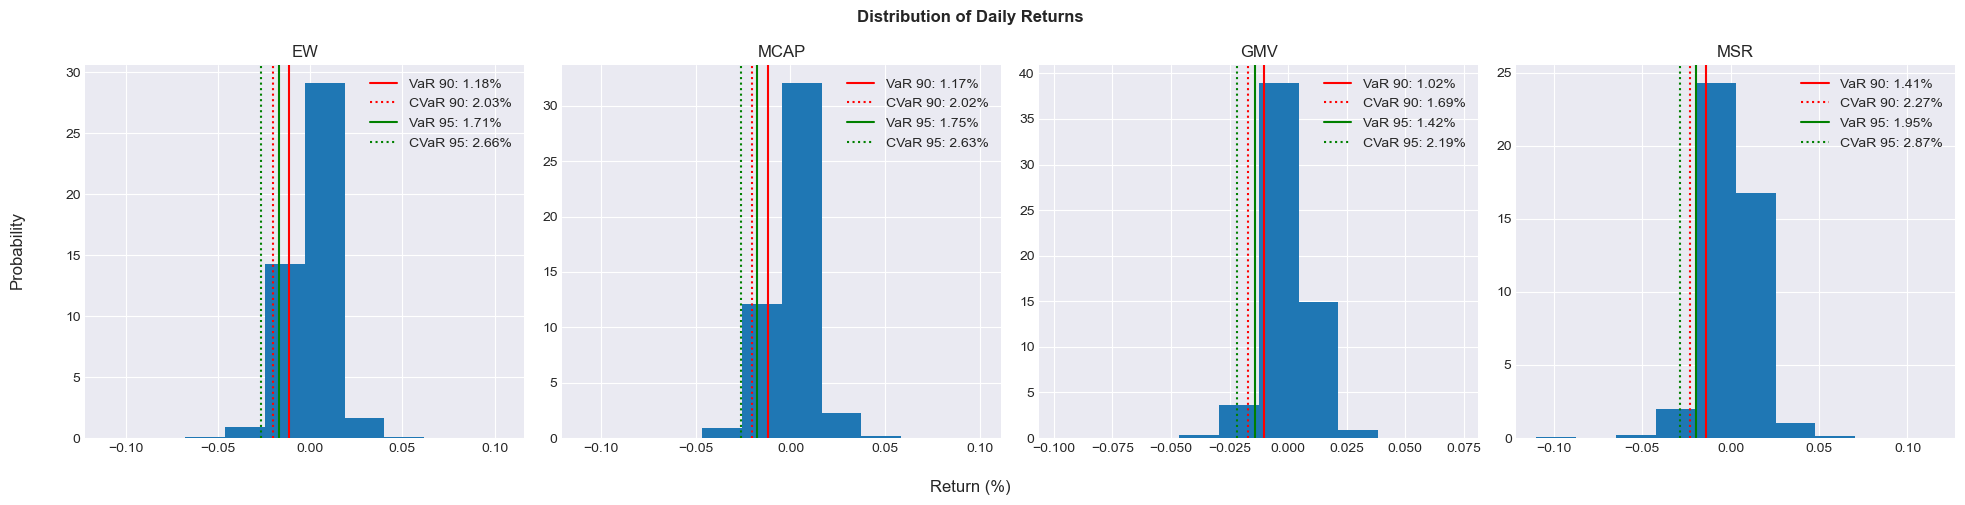

In [103]:
portfolios = portfolio_returns.columns
fig = plt.figure(figsize=(20,5))
var_H_port = []
cvar_H_port = []
for portfolio,num in zip(portfolios,range(4)):
    portfolio_ret = portfolio_returns[portfolio]
    # Sorting the returns for plotting
    portfolio_ret = portfolio_ret.sort_values()
    plt.subplot(1,4,num+1)
    # Plot the probability of each return quantile
    plt.hist(portfolio_ret, density=True)
    # HS VaR and CVaR 90,95,99
    var_levels = [90,95]
    colors = ['r','g']
    for var_level,color in zip(var_levels,colors):
        var_H = np.percentile(portfolio_ret, 100-var_level)
        plt.axvline(x=var_H, color=color, linestyle="-", label=f'VaR {var_level}: {-var_H*100:.2f}%')
        cvar_H = portfolio_ret[portfolio_ret <= var_H].mean()
        cvar_H_port.append(cvar_H)
        plt.axvline(x=cvar_H, color=color, linestyle=":", label=f'CVaR {var_level}: {-cvar_H*100:.2f}%')
        plt.title(f'{portfolio}')
        plt.legend(loc='upper right',frameon=False)
    plt.suptitle('Distribution of Daily Returns', weight='bold')
    fig.supylabel('Probability'), fig.supxlabel('Return (%)')
    plt.tight_layout(rect=(0.025,0,1,1))
    # Calculating maximum historical daily loss
    var_H = np.percentile(portfolio_ret, 100-95)
    cvar_95_H_min = portfolio_ret[portfolio_ret <= var_H].min()
    print(f'Max historical daily loss (95) - {portfolio}: {-cvar_95_H_min*100:.2f}%')

VaR (95) of GMV portoflio indicates that we can be 95% certain that losses will not exceed 1.43% in a given day. What about the losses that exceed this amount? CVaR (95) tells us that in the worst 5% cases, GMV portfolio daily losses will be on average 2.22%, with a maximum value of 9.78%.

Interestingly, the maximum historical loss of the minimum variance portfolio is greater than that of the tangency portfolio.

### VaR over n-day time period
We can calculate the VaR over a longer time window as well. For that, just take our 1 day VaR estimate and multiply it by the square root of the desired time period.

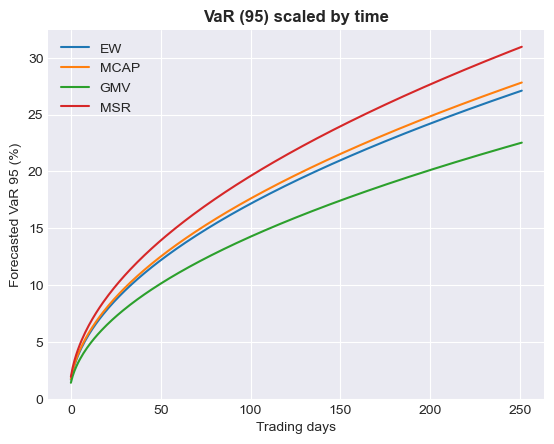

In [104]:
# Aggregate forecasted VaR
forecasted_val = np.empty([252, 2]) 

# Loop through each forecast period
data=[]
for portfolio in portfolios:
    forecasted_val = np.empty([252, 2])
    portfolio_ret = portfolio_returns[portfolio]
    portfolio_ret = portfolio_ret.sort_values()
    for i in range(0,252):
        # Save the time horizon i
        forecasted_val[i, 0] = i
        # Save the forecasted VaR 95
        forecasted_val[i, 1] = np.percentile(portfolio_ret, 100-95) * np.sqrt(i+1)
    # Data for plotting
    x = forecasted_val[:,0]
    y = forecasted_val[:,1]*(-100)
    plt.plot(x,y, label=portfolio)
plt.title('VaR (95) scaled by time', weight='bold')
plt.ylabel('Forecasted VaR 95 (%)'), plt.xlabel('Trading days')
plt.legend(loc=0, frameon=False)
plt.show()

### Parametric (Variance-Covariance) Method
This approach assumes a normal distribution of returns, meaning we only need to estimate two factors - the expected return and the standard deviation - which allows us to plot a normal distribution curve.

In [123]:
from scipy.stats import norm
# Normal distribution assumption
def parametric_var(portfolio,alpha):
    portfolio_ret = portfolio_returns[portfolio]
    mu = np.mean(portfolio_ret)
    std = np.std(portfolio_ret)
    return mu - norm.ppf(alpha)*std

def parametric_cvar(portfolio,alpha):
    portfolio_ret = portfolio_returns[portfolio]
    mu = np.mean(portfolio_ret)
    std = np.std(portfolio_ret)
    return mu + alpha**-1 * norm.ppf(alpha)*std

var_p_table = pd.DataFrame()
for portfolio in portfolios:
    var_p = parametric_var(portfolio,0.05)
    cvar_p = parametric_cvar(portfolio,0.05)
    var_p_table_temp = pd.DataFrame({'Parametric VaR (95)':var_p,'Parametric CVaR (95)':cvar_p}, 
                                    index=[portfolio])
    for col in var_p_table_temp[-2:]:
        var_p_table_temp[col] = var_p_table_temp[col].apply(lambda x: "{:.2f}%".format(x*100))
    var_p_table = pd.concat((var_p_table,var_p_table_temp))
var_p_table

Parametric VaR (95) Parametric CVaR (95)
EW                 1.86%              -36.69%
MCAP               1.86%              -36.58%
GMV                1.54%              -30.40%
MSR                2.16%              -42.27%

### Monte Carlo Method
Monte Carlo Simulation is similar to Historical Simulation in that it estimates VaR by simulating risk factor scenarios and revaluing all positions in a portfolio for each trial. Nevertheless, it generates the risk factor scenarios through the lognormal distribution,instead of creating them from a historical distribution.

This way, both models share the same distribution assumption for risk factors, but the approach for generating the price distribution of the asset isn't the same. We estimate value at risk by calculating the change in value for each scenario and looking at the worst losses.

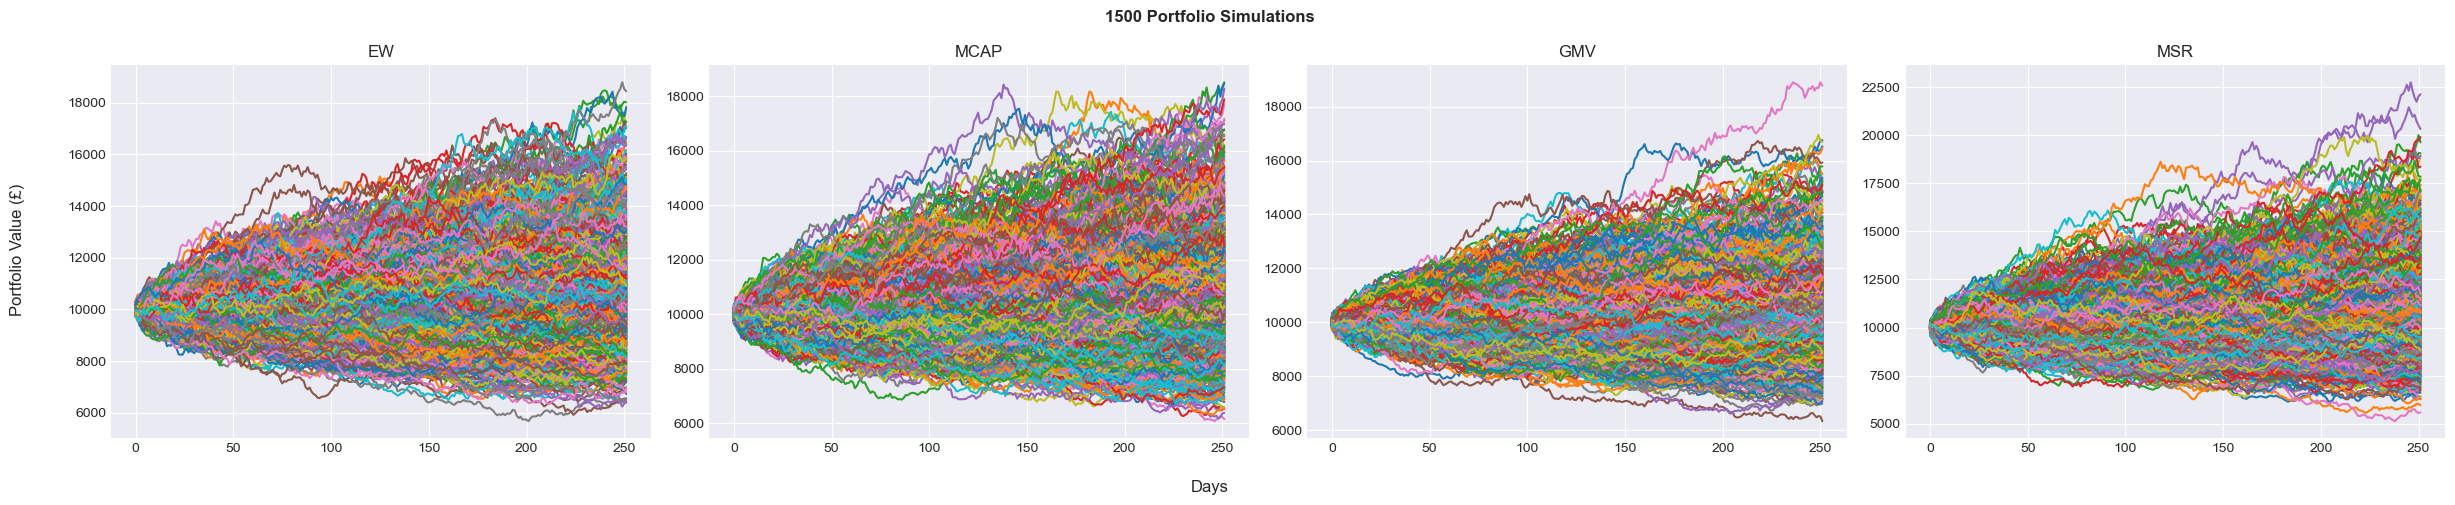

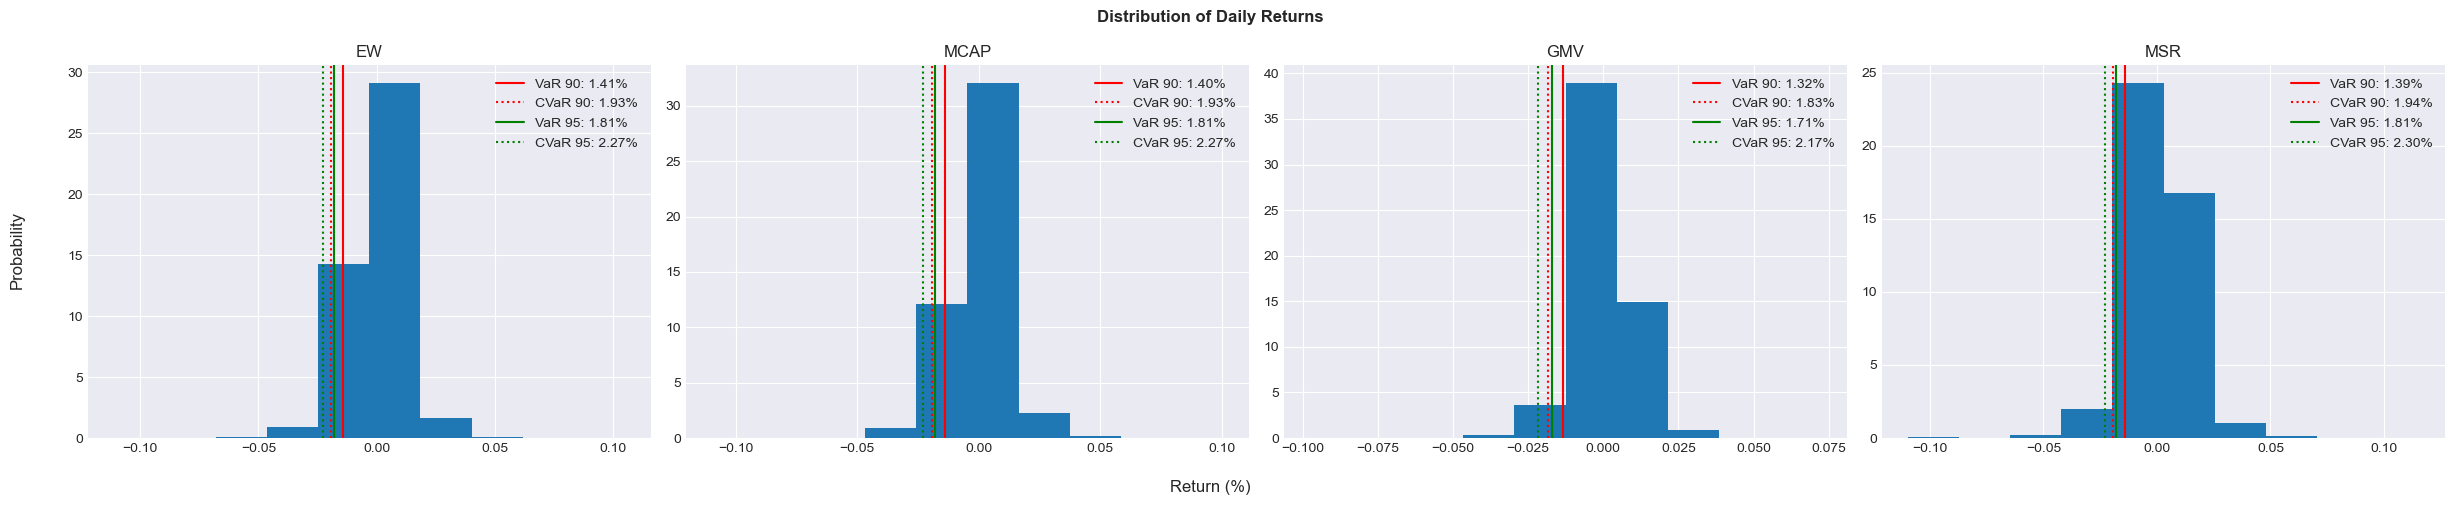

In [106]:
trading_days = 252 # forecast period
S0 = 10000 # initial portfolio value
simulations_number = 1500 # number of simulations
sim_returns = []
fig_0 = plt.figure(0,figsize=(25,5))
fig_1 = plt.figure(1,figsize=(25,5))
colors = ['r','g']
var_levels = [90,95]
for portfolio,num in zip(portfolios,range(4)):
    portfolio_ret = portfolio_returns[portfolio]
    mu = np.mean(portfolio_ret)
    std = np.std(portfolio_ret)
    # Loop through 100 simulations
    plt.figure(0)
    for i in range(simulations_number):
        random_rets = np.random.normal(mu, std, trading_days)   
        forecasted_values = S0*(random_rets+1).cumprod()-1
        sim_returns.append(random_rets)
        # Show the simulations
        plt.subplot(1,4,num+1)
        plt.plot(range(trading_days), forecasted_values)
        plt.title(f'{portfolio}')
    plt.suptitle('1500 Portfolio Simulations', weight='bold')
    fig_0.supylabel('Portfolio Value (£)'), fig_0.supxlabel('Days')
    plt.tight_layout(rect=(0.025,0,1,1))
    # Returns distribution
    plt.figure(1)
    plt.subplot(1,4,num+1)
    plt.hist(portfolio_ret, density=True)
    for var_level,color in zip(var_levels,colors):
        var_mc = np.percentile(sim_returns, 100-var_level)
        cvar_mc = np.array(sim_returns)[np.array(sim_returns) <= var_mc].mean()
        plt.axvline(x=var_mc, color=color, linestyle="-", 
                    label=f'VaR {var_level}: {-var_mc*100:.2f}%')
        plt.axvline(x=cvar_mc, color=color, linestyle=":",
                    label=f'CVaR {var_level}: {-cvar_mc*100:.2f}%')
        plt.title(f'{portfolio}')
        plt.legend(loc='upper right',frameon=False)
    plt.suptitle('Distribution of Daily Returns', weight='bold')
    fig_1.supylabel('Probability'), fig_1.supxlabel('Return (%)')
    plt.tight_layout(rect=(0.025,0,1,1))


### Expected losses of our investment portfolio
95% Value at Risk of £10,000 investment in each portfolio over different time frames

In [124]:
from scipy.stats import norm
def var(method,portfolio, investment, time_frame, confidence_level):
    # time horizon of VaR
    if time_frame == 'day':
        days = 1
    elif time_frame == 'month':
        days = 21
    elif time_frame == 'quarter':
        days = 63
    elif time_frame == 'year':
        days = 252
    else:
        raise ValueError ('time_frame input invalid.')
    
    portfolio_ret = portfolio_returns[portfolio]
    mu = np.mean(portfolio_ret)
    std = np.std(portfolio_ret)

    # Var estimation method
    if method=='parametric':
        alpha = (100-confidence_level)/100
        var = investment*(mu-norm.ppf(alpha)*std)*np.sqrt(days)
        return var
    elif method=='historical':
        portfolio_ret = portfolio_ret.sort_values()
        var = investment*(-np.percentile(portfolio_ret, 100-confidence_level)*np.sqrt(days))
        return var
    elif method=='monte carlo':
        for i in range(1500):
            random_rets = np.random.normal(mu, std, 252)
            forecasted_values = 10*(random_rets+1).cumprod()-1
            sim_returns.append(random_rets)
        var = investment*(-np.percentile(sim_returns, 100-confidence_level)*np.sqrt(days))
        return var
    else:
        raise ValueError ('method input invalid')
        
var_table = pd.DataFrame()
methods = ['historical','parametric','monte carlo']
for method in methods:
    for portfolio in portfolios:
        # Portfolio VaR calculation for each time horizon:
        var_p_d = var(method=method, portfolio=portfolio,investment = 10000, time_frame='day',
                    confidence_level=95)
        var_p_m = var(method=method, portfolio=portfolio, investment = 10000, time_frame='month',
                    confidence_level=95)
        var_p_q = var(method=method, portfolio=portfolio, investment = 10000, time_frame='quarter',
                    confidence_level=95)
        var_p_y = var(method=method, portfolio=portfolio, investment = 10000, time_frame='year',
                    confidence_level=95)
        var_table_temp = pd.DataFrame({'Method':method,'Daily':[var_p_d],'Monthly':[var_p_m], 
                                        'Quarterly':[var_p_q], 'Annual':[var_p_y]}, index=[portfolio])
        # Format numbers as currency
        for col in var_table_temp.columns[-4:]:
            var_table_temp[col]= var_table_temp[col].apply(lambda x: "£{:,.1f}".format(x))
        var_table = pd.concat([var_table,var_table_temp])
var_table

Method   Daily Monthly Quarterly    Annual
EW     historical  £170.7  £782.2  £1,354.9  £2,709.8
MCAP   historical  £175.2  £802.9  £1,390.6  £2,781.2
GMV    historical  £141.9  £650.3  £1,126.4  £2,252.7
MSR    historical  £195.0  £893.5  £1,547.7  £3,095.3
EW     parametric  £186.0  £852.3  £1,476.1  £2,952.3
MCAP   parametric  £185.9  £851.9  £1,475.5  £2,951.1
GMV    parametric  £153.9  £705.2  £1,221.5  £2,443.0
MSR    parametric  £216.5  £992.1  £1,718.3  £3,436.6
EW    monte carlo  £180.4  £826.7  £1,432.4  £2,865.3
MCAP  monte carlo  £180.5  £827.0  £1,432.4  £2,864.6
GMV   monte carlo  £179.4  £818.2  £1,410.0  £2,807.1
MSR   monte carlo  £177.8  £818.7  £1,425.0  £2,862.4

According to historical method, with 95 percent confidence level, our losses from a £10,000 investment in MSR portfolio won't exceed the value of £854.2 in a given month.

Parametric and Monte Carlo approaches estimate higher VaR than the historical method.

Unlike the other methods, there's very litle disparity in values when using Monte Carlo Simulation approach.